In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from numpy import genfromtxt
%matplotlib inline
np.random.seed(1)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def random_mini_batches(X, Y, mini_batch_size = 32, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    #  Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [11]:
import os
os.chdir('/Users/mash/Downloads/Sensie_download_02-16-2018')

In [12]:
# Loading the dataset


# data format being loaded: 
# no headers
# first column is the "tag" or expected outcom, 0 is "Stress present", 1 si"Stress free"
# second column is the user's email
# third column indicates if the user is left handed (represented by a 1) or right handed (represented by 0)
# columns 4 to 903 (inclusive) represent gyroscope data gatered for 3 seconds at 100Hz 
# columns 4 to 303 (inclusive) are for Yaw
# columns 304 to 603 (inclusive) are for Roll
# columns 604 to 903 (inclusive) are for Pitch

test_data = genfromtxt('MasterShuffle_test.csv', delimiter=',', skip_header=1)
train_data = genfromtxt('MasterShuffle_train.csv', delimiter=',', skip_header=1)



print("Full train set shape ",train_data.shape)
print("Full test set shape ",test_data.shape)


#eliminate NaN's
test_data = np.delete(test_data, np.unique(np.argwhere(np.isnan(test_data[:,3:])).T[0].flatten('C')), axis=0)
train_data = np.delete(train_data, np.unique(np.argwhere(np.isnan(train_data[:,3:])).T[0].flatten('C')), axis=0)



print("Train set shape W/O NAN ",train_data.shape)
print("Test set shape W/O NAN ",test_data.shape)


Y_train_orig = train_data[:,0].astype(int)
X_train_orig = train_data[:,3:]


Y_test_orig = test_data[:,0].astype(int)
X_test_orig = test_data[:,3:]


print("Final train set shape ",X_train_orig.shape)
print("Final train expected outcome set shape ",Y_train_orig.shape)


print("Final test set shape ",X_test_orig.shape)
print("Final test expected outcome set shape ",Y_test_orig.shape)




Full train set shape  (2440, 903)
Full test set shape  (1045, 903)
Train set shape W/O NAN  (2363, 903)
Test set shape W/O NAN  (1014, 903)
Final train set shape  (2363, 900)
Final train expected outcome set shape  (2363,)
Final test set shape  (1014, 900)
Final test expected outcome set shape  (1014,)


Stress free


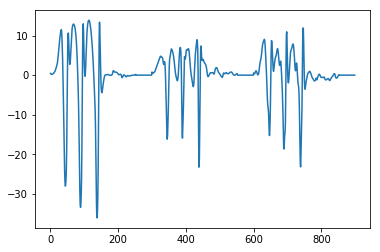

In [13]:
# print some range of Sress free samples
print("Stress free")

for i in range(2,3):
    if Y_train_orig[i]:
        plt.plot((X_train_orig[i]))

# print ("y = " + str(Y_test_orig[index]))


Stress full


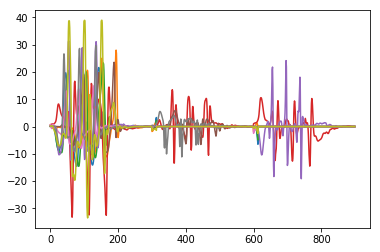

In [14]:
# print some range of Sressfull samples

print("Stress full")
for i in range(300,320):
    if not Y_train_orig[i]:
        plt.plot((X_train_orig[i]))

In [15]:
# reshape the data for the neural network input


# use convert_to_one_hot to have the output behave as a softmax

Y_train = convert_to_one_hot(Y_train_orig.reshape(Y_train_orig.shape[0],1), 2)
Y_test = convert_to_one_hot(Y_test_orig.reshape(Y_test_orig.shape[0],1), 2)

X_train = X_train_orig
X_test = X_test_orig

   
# normalize and transpose the input

X_train = np.array(X_train)/100
X_train = X_train.T  - np.nanmax(X_train)

X_test = np.array(X_test)/100
X_test = X_test.T  - np.nanmax(X_test)



print("Train data reshaped ",X_train.shape)
print("Test data reshaped ",X_test.shape)



Train data reshaped  (900, 2363)
Test data reshaped  (900, 1014)


In [16]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (900)
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)
    
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape = (n_x,None))
    Y = tf.placeholder(tf.float32, shape = (n_y,None))
    
    return X, Y

In [17]:
X, Y = create_placeholders(900, 2)
print ("X = " + str(X))
print ("Y = " + str(Y))


X = Tensor("Placeholder:0", shape=(900, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(2, ?), dtype=float32)


In [18]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [2, 900]
                        b1 : [2, 1]

                     
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1
    """
    
    tf.set_random_seed(1)                   
        
 
    W1 = tf.get_variable("W1", [2,900], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [2,1], initializer = tf.zeros_initializer())


    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1}
    
    return parameters


In [19]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))


W1 = <tf.Variable 'W1:0' shape=(2, 900) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(2, 1) dtype=float32_ref>


In [20]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR ->  SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1"
                  the shapes are given in initialize_parameters

    Returns:
    Z2 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']


    
                                                            # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                        # Z1 = np.dot(W1, X) + b1


    
    return Z1

In [21]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(900, 2)
    parameters = initialize_parameters()
    Z1 = forward_propagation(X, parameters)
    print("Z1 = " + str(Z1))

Z1 = Tensor("Add:0", shape=(2, ?), dtype=float32)


In [22]:
def compute_cost(Z1, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (2, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.sigmoid_cross_entropy_with_logits(...,...)
    logits = Z1 #tf.transpose(Z2)
    labels = Y #tf.transpose(Y)
    
   
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    
    return cost

In [23]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(900, 2)
    parameters = initialize_parameters()
    Z2 = forward_propagation(X, parameters)
    cost = compute_cost(Z2, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [24]:

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 3, minibatch_size = 32, print_cost = True):



    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 900, number of training examples = 2363)
    Y_train -- test set, of shape (output size = 2, number of training examples = 2363)
    X_test -- training set, of shape (input size = 900, number of training examples = 1014)
    Y_test -- test set, of shape (output size = 2, number of test examples = 1014)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
   
    X, Y = create_placeholders(n_x, n_y)
  

    # Initialize parameters

    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph

    Z1 = forward_propagation(X, parameters)

    
    # Cost function: Add cost function to tensorflow graph

    cost = compute_cost(Z1, Y)

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
               
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z1), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 56.094770


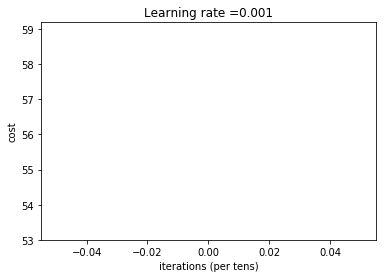

Parameters have been trained!
Train Accuracy: 0.5687685
Test Accuracy: 0.5729783


In [25]:
parameters = model(X_train, Y_train, X_test, Y_test)


Following section from <b>DL for Developers</b> https://medium.freecodecamp.org/deep-learning-for-developers-tools-you-can-use-to-code-neural-networks-on-day-1-34c4435ae6b

In [1]:
# 1. Import library of functions
import tflearn
# 2. Logical OR operator / the data
OR = [[0., 0.], [0., 1.], [1., 0.], [1., 1.]]
Y_truth = [[0.], [1.], [1.], [1.]]
# 3. Building our neural network/layers of functions 
neural_net = tflearn.input_data(shape=[None, 2])
neural_net = tflearn.fully_connected(neural_net, 1, activation='sigmoid', bias=False)
neural_net = tflearn.regression(neural_net, optimizer='sgd', learning_rate=2, loss='mean_square')
# 4. Train the neural network / Epochs
model = tflearn.DNN(neural_net)
model.fit(OR, Y_truth, n_epoch=2000, snapshot_epoch=False)
# 5. Testing final prediction
print("Testing OR operator")
print("0 or 0:", model.predict([[0., 0.]]))
print("0 or 1:", model.predict([[0., 1.]]))
print("1 or 0:", model.predict([[1., 0.]]))
print("1 or 1:", model.predict([[1., 1.]]))

Training Step: 2000  | total loss: 0.06279 | time: 0.002s
| SGD | epoch: 2000 | loss: 0.06279 -- iter: 4/4
Testing OR operator
0 or 0: [[0.5]]
0 or 1: [[0.98173404]]
1 or 0: [[0.9825822]]
1 or 1: [[0.99967027]]
